In [2]:
from surface_distribution import plot_surface_dist
from mmseg.datasets.pipelines import Compose
from mmcv import Config
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from typing import Tuple, Union, Literal

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
g = np.random.default_rng()
label = Image.open("data/I3/labels/1.png").convert("P")
sam = Image.open("data/I3/sam/1.png").convert("P")
label = torch.from_numpy(np.array(label))
sam = torch.from_numpy(np.array(sam))

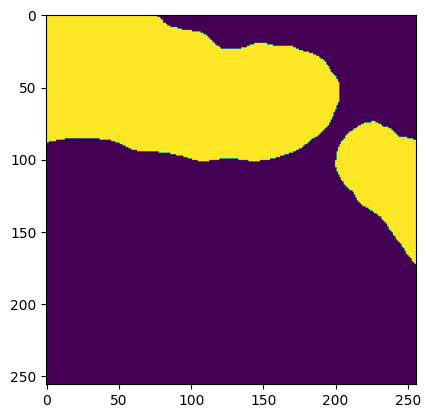

In [13]:
plt.imshow(label)

In [15]:
label.unique()

tensor([0, 1], dtype=torch.uint8)

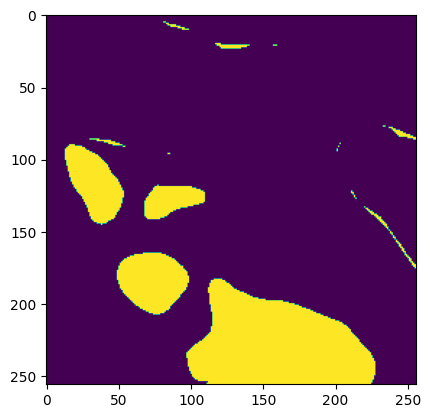

In [20]:
plt.imshow(sam.where(label !=1 , torch.tensor(0, dtype=label.dtype)))

In [ ]:
def delete_intersection(ema:torch.Tensor,sam:torch.Tensor):
    return ema,sam.where(label !=1 , torch.tensor(0, dtype=label.dtype))


In [ ]:
def randomly_add_mask_region(
    mask: torch.Tensor,
    shape: Union[Literal['circle'], Literal['square'], Literal['random']] = 'random',
    size_range: Tuple[int, int] = (10, 50),
    num_deletions: int = 1,
    seed: int = None
) -> torch.Tensor:

    if seed is not None:
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
    
    # Handle different input shapes
    original_shape = mask.shape
    if len(mask.shape) == 2:
        # (H, W)
        mask_2d = mask.clone()
    elif len(mask.shape) == 3:
        # (1, H, W) or (C, H, W)
        mask_2d = mask.squeeze(0).clone()
    elif len(mask.shape) == 4:
        # (B, 1, H, W) or (B, C, H, W)
        mask_2d = mask.squeeze().clone()
    else:
        raise ValueError(f"Unsupported mask shape: {mask.shape}")
    
    height, width = mask_2d.shape
    
    for _ in range(num_deletions):
        # Randomly choose shape if 'random' is specified
        current_shape = shape
        if shape == 'random':
            current_shape = random.choice(['circle', 'square'])
        
        # Random size within the specified range
        size = random.randint(size_range[0], size_range[1])
        
        # Random center position (ensuring the shape fits within bounds)
        center_x = random.randint(size, width - size - 1)
        center_y = random.randint(size, height - size - 1)
        
        if current_shape == 'circle':
            # Create circular deletion
            radius = size // 2
            y_coords, x_coords = torch.meshgrid(
                torch.arange(height, dtype=torch.float32),
                torch.arange(width, dtype=torch.float32),
            )
            x_coords = x_coords.to(mask_2d.device)
            y_coords = y_coords.to(mask_2d.device)
            # Calculate distance from center
            distances = torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)
            circle_mask = distances <= radius
            
            # Set pixels within circle to 0
            mask_2d[circle_mask] = 1
            
        elif current_shape == 'square':
            # Create square deletion
            half_size = size // 2
            
            # Define square boundaries
            y_start = max(0, center_y - half_size)
            y_end = min(height, center_y + half_size)
            x_start = max(0, center_x - half_size)
            x_end = min(width, center_x + half_size)
            
            
            # Set pixels within square to 0
            mask_2d[y_start:y_end, x_start:x_end] = 1

    # Reshape back to original shape
    if len(original_shape) == 2:
        return mask_2d
    elif len(original_shape) == 3:
        return mask_2d.unsqueeze(0)
    elif len(original_shape) == 4:
        return mask_2d.unsqueeze(0).unsqueeze(0)

def visualize_mask_augmentation(original_mask: torch.Tensor, modified_mask: torch.Tensor, prefix="Ema"):
    """
    Helper function to visualize the original and modified masks side by side.
    Requires matplotlib.
    """
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Convert to numpy for visualization
        orig_np = original_mask.squeeze().cpu().numpy() if isinstance(original_mask, torch.Tensor) else original_mask
        mod_np = modified_mask.squeeze().cpu().numpy() if isinstance(modified_mask, torch.Tensor) else modified_mask
        
        ax1.imshow(orig_np, cmap='gray')
        ax1.set_title(f'Original {prefix} Mask')
        ax1.axis('off')
        
        ax2.imshow(mod_np, cmap='gray')
        ax2.set_title(f'Augmented {prefix} Mask')
        ax2.axis('off')
        
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("matplotlib not available for visualization")


In [193]:
label_modified = randomly_add_mask_region(label,num_deletions=10)
sam_modified = randomly_add_mask_region(sam,num_deletions=10)

In [194]:
label_modified.unique()

tensor([0, 1], dtype=torch.uint8)

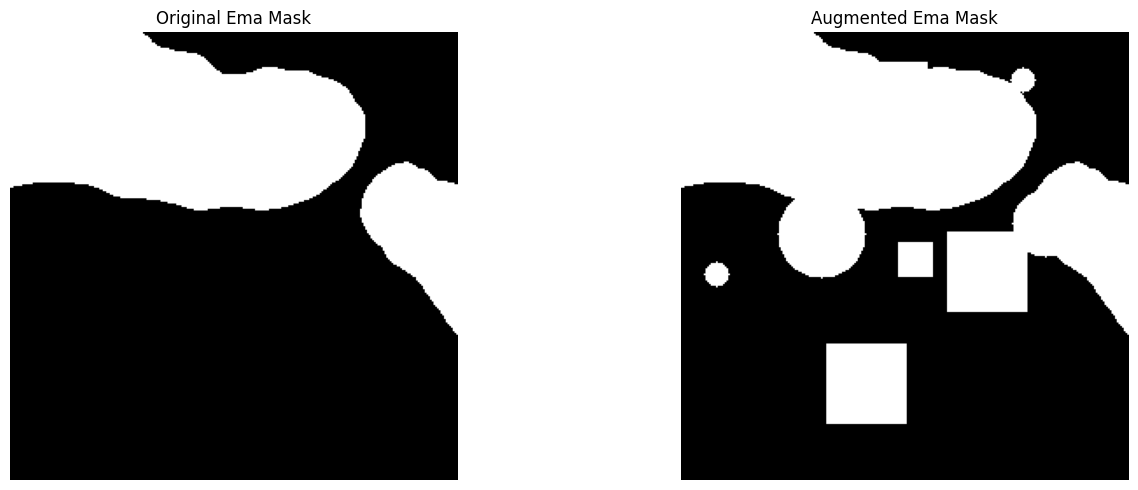

In [195]:
visualize_mask_augmentation(label,label_modified)

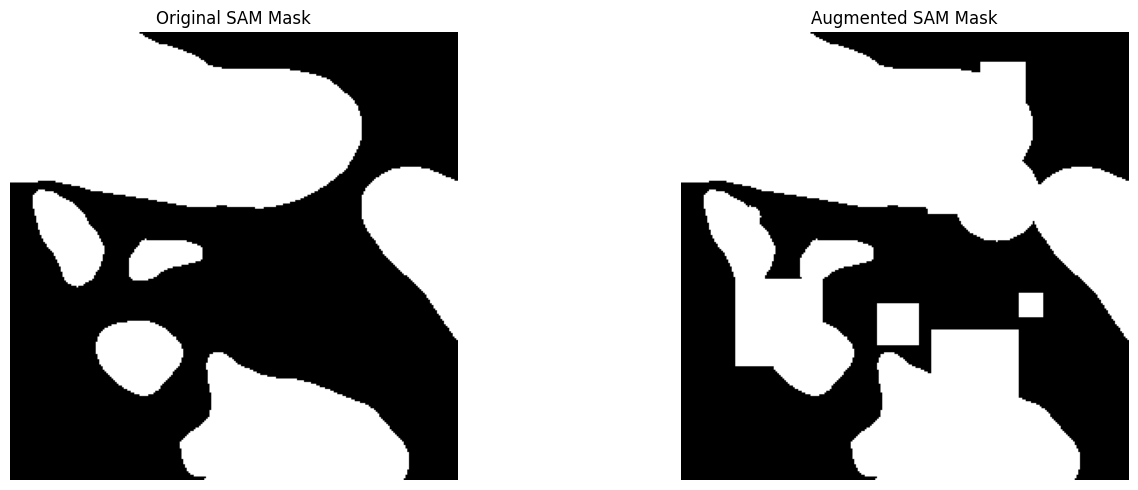

In [196]:
visualize_mask_augmentation(sam,sam_modified,"SAM")

In [21]:
from mmseg.datasets import GTADataset

In [ ]:
dataset = GTADataset()